In [1]:
import sys
sys.path.append("D:/Zoo/Gull/geoVeRoPy")
import geoVeRoPy
import shapely
import matplotlib.pyplot as plt

import math
import random
# %matplotlib notebook

## Solving TSP with different IP formulations

In this notebook, we are going to demostrate the efficiency of different IP formulations for solving the TSP. Including
- DFJ formulation
    - Lazy cut (when we find a violation of subtour constraint, add the lazy cut and go on)
    - Plain loop (when we find a violation of subtour constraint, restart the IP)
- MTZ formulation
- Multi-commodity formulation
- Shortest path formulation (or time-staged formulation)
- Quadratic formulation

### 0. Preparation
In this section, we will randomly generate TSP instances

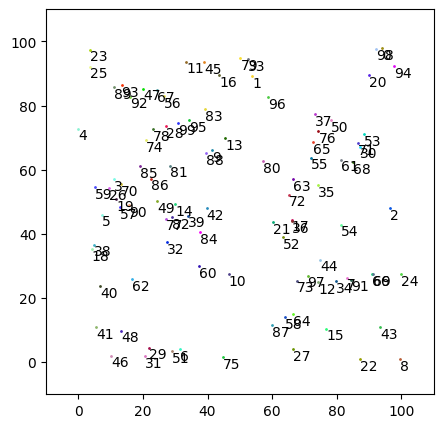

In [2]:
# Generate and plot instance
nodes = geoVeRoPy.rndNodes(
    N = 100,
    distr = 'UniformSquareXY',
    xRange = (0, 100),
    yRange = (0, 100)
)
fig, ax = geoVeRoPy.plotNodes(
    nodes = nodes, 
    boundingBox = (0, 100, 0, 100)
)

In [3]:
geoVeRoPy.setLog("DEBUG_PRINT_LOG", False)

### 1. DFJ formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V \label{TSP:con:degree1}\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V \label{TSP:con:degree2}\\
				      & \sum_{j\notin S, i\in S, (i,j)\in A} x_{ij} \ge 1, \quad \forall S \subset V, 2\le |S| \le n-1 \label{TSP:con:DFJSubtour1}\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A   
\end{align}




In [11]:
# DFJ with lazy cut
DFJ_Lazy = geoVeRoPy.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'DFJ_Lazy',
    solver = 'Gurobi',
    detailsFlag = False,
    outputFlag = False)

In [5]:
DFJ_Lazy['ofv'], DFJ_Lazy['runtime']

(765.5822602352339, 3.863903045654297)

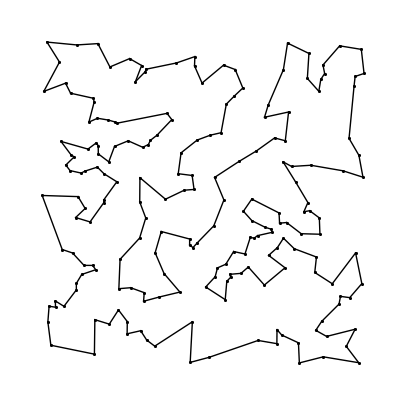

In [12]:
# Plot the result of TSP
fig, ax = geoVeRoPy.plotNodeSeq(
#     fig = fig,
#     ax = ax,
    nodes = nodes, 
    nodeSeq = DFJ_Lazy['seq'],
    lineColor = 'black',
    showAxis = False)

In [13]:
fig.savefig("TSP.png")

In [7]:
# DFJ with plain loop
DFJ_Plainloop = geoVeRoPy.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'DFJ_Plainloop',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 3)
print(DFJ_Plainloop)

{'ofv': 470.94107664605053, 'seq': [0, 17, 8, 25, 11, 28, 6, 9, 5, 16, 29, 1, 19, 2, 26, 18, 14, 27, 23, 22, 4, 10, 12, 21, 20, 15, 24, 13, 7, 3, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 470.94107664605053, 'upperBound': 470.94107664605053, 'runtime': 0.235459}


The following figure shows the result for TSP, since every formulation will yield to the same result, we are not going to repeat this part

### 2. MTZ formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

Define $t_i$ as the time of visisting vertex $i$

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V\\
					  & t_i + \tau_{ij} \le t_j  + M(1 - x_{ij}), \quad i, j = 2, \cdots, n \in V, (i, j) \in A\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A\\
					  & t_i \ge 0, \quad i \in 1, \cdots, n \in V
\end{align}


In [8]:
# MTZ
MTZ = geoVeRoPy.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'MTZ',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 10)
print(MTZ)

{'ofv': 470.9410766460506, 'seq': [0, 3, 7, 13, 24, 15, 20, 21, 12, 10, 4, 22, 23, 27, 14, 18, 26, 2, 19, 1, 29, 16, 5, 9, 6, 28, 11, 25, 8, 17, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 470.9410766460506, 'upperBound': 470.9410766460506, 'runtime': 2.00945}


### 3. Multi-Commodity flow formulation

Define the decision variable $x_{ij}$ as the following

\begin{equation}
    x_{ij} = \begin{cases}
        1, &\text{if goes from } i \text{ to } j\\ 
        0, & \text{otherwise}
    \end{cases}, \quad (i, j) \in A
\end{equation}

Define $y_{ij}^k$ as commodity flow for the $k$th commodity when traveling through edge $(i, j)$

IP formulation:


\begin{align}
    \min \quad &\sum_{(i, j)\in A} c_{ij}x_{ij}\\
    \text{s.t.} \quad & \sum_{j \in V, (i,j)\in A} x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V, (i,j)\in A} x_{ij} = 1, \quad \forall j \in V\\
					  & y_{ij}^k \le x_{ij}, \quad \forall i, j, k \in N, k \neq 1\\
					  & \sum_{i \in V} y_{1i}^k = 1, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{i1}^k = 0, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{ik}^k = 1, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{j \in V} y_{kj}^k = 0, \quad \forall k \in V \setminus \{1\}\\
					  & \sum_{i \in V} y_{ij}^k - \sum_{i \in V} y_{ji}^k = 0, \quad \forall j, k \in V \setminus \{1\}, j \neq k\\
                      & x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A\\
                      & y_{ij}^k \in \mathbb{Z}, \quad \forall i, j, k \in N, k \neq 1\\
\end{align}


In [9]:
# MultiCommodityFlow
MultiCommodityFlow = geoVeRoPy.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'MultiCommodityFlow',
    solver = 'Gurobi',
    outputFlag = False)
print(MultiCommodityFlow)

{'ofv': 470.94107664605053, 'seq': [0, 17, 8, 25, 11, 28, 6, 9, 5, 16, 29, 1, 19, 2, 26, 18, 14, 27, 23, 22, 4, 10, 12, 21, 20, 15, 24, 13, 7, 3, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 470.94107664605053, 'upperBound': 470.94107664605053, 'runtime': 7.546439}


### 4. Shortest path formulation (time-staged formulation)

Define $x_{ij}^t$ as the following

\begin{equation}
    x_{ij}^t = \begin{cases}
                    1, \quad \text{If path crosses arc } (i, t) \text{ and } (j, t + 1) \\
                    0, \quad \text{Otherwise}
                \end{cases}, \quad i \in V, j \in V \setminus \{i\}, t = 1, \cdots, n
\end{equation}

IP formulation:

\begin{align}
    \min \quad &\sum_{i \in V}\sum_{j \in V\setminus \{i\}} c_{ij} \sum_{t = 1}^n x_{ij}^t\\
    \text{s.t.} \quad &\sum_{j \in V \setminus \{1\}} x_{1j}^1 = 1\\
    &\sum_{j \in V \setminus \{1, i\}} x_{ij}^2 - x_{1i}^1 = 0, \quad \forall i \in V \setminus \{1\} \\
    &\sum_{j \in V \setminus \{1, i\}} x_{ij}^t - \sum_{j \in V \setminus \{1, i\}} x_{ji}^{t - 1} = 0, \quad \forall i \in V \setminus \{1\}, t \in \{2, \dots, n - 1\}\\
    &x_{i1}^n - \sum_{j \in V \setminus \{1, i\}} x_{ji}^{n - 1} = 0, \quad \forall i \in V \setminus \{1\} \\
    &\sum_{i \in V \setminus \{1\}} x_{i1}^n = 1\\
    &\sum_{t = 2}^{n - 1}\sum_{j \in V \setminus \{1, i\}} x_{ij}^t + x_{i1}^n \le 1, \quad \forall i \in V \setminus \{1\}\\ 
    &x_{1i}^1 + \sum_{t = 2}^{n - 1}\sum_{j \in V \setminus \{1, i\}} x_{ji}^t \le 1, \quad \forall i \in V \setminus \{1\}\\
\end{align}

In [10]:
# ShortestPath
ShortestPath = geoVeRoPy.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'ShortestPath',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 180)
print(ShortestPath)

{'ofv': 470.9410707429944, 'seq': [0, 17, 8, 25, 11, 28, 6, 9, 5, 16, 29, 1, 19, 2, 26, 18, 14, 27, 23, 22, 4, 10, 12, 21, 20, 15, 24, 13, 7, 3, 0], 'gap': 0, 'solType': 'IP_Optimal', 'lowerBound': 470.9410707429944, 'upperBound': 470.9410707429944, 'runtime': 132.133298}


### 5. Quadratic formulation

Assuming we have $n$ boxes, which represents $n$ steps in the path. Define $x_{ij}$ as 

\begin{equation}
    x_{ij} = \begin{cases}
                1, \quad \text{Vertex $i$ is assigned to box $j$}\\
                0, \quad \text{Otherwise}
            \end{cases}
\end{equation}

IP formulation:

\begin{align}
    \min \quad & \sum_{i \in V} \sum_{j \in V \setminus \{i\}} \sum_{k = 1}^{n - 1} c_{ij} w_{ij}^k + \sum_{i \in V} \sum_{j \in V \setminus \{i\}} c_{ij}w_{ij}^n\\
    \text{s.t.} \quad & \sum_{j = 1}^n x_{ij} = 1, \quad \forall i \in V\\
                      & \sum_{i \in V}^n x_{ij} = 1, \quad j = 1, \dots, n\\
                      & w_{ij}^k \ge x_{ik} + x_{j, k + 1} - 1, \quad i \in V,  j \in V \setminus \{i\}, k = 1, \cdots, n - 1\\
                      & w_{ij}^k \ge x_{ik} + x_{j1} - 1, \quad i \in V, j \in V \setminus \{i\}, k = n \\
                      & w_{ij}^k \in \{0, 1\}, \quad i \in V, j \in V \setminus \{i\}, k = 1, \dots, n\\
                      & x_{ij} \in \{0, 1\}, \quad i \in V, j \in V \setminus \{i\}
\end{align}

In [11]:
# QAP
QAP = geoVeRoPy.solveTSP(
    nodes = nodes, 
    edges = 'Euclidean',
    algo = 'IP',
    fml = 'QAP',
    solver = 'Gurobi',
    outputFlag = False,
    timeLimit = 180)
print(QAP)

{'ofv': 709.7268057225604, 'seq': [0, 7, 13, 24, 15, 20, 4, 10, 22, 2, 19, 29, 6, 9, 28, 5, 16, 1, 18, 14, 12, 21, 17, 26, 27, 23, 3, 11, 8, 25, 0], 'gap': 0.971659436672179, 'solType': 'IP_TimeLimit', 'lowerBound': 20.11405748303235, 'upperBound': 709.7268057225605, 'runtime': 180.792381}


### 6. Insertion + 2Opt

In [12]:
InsertionAnd2Opt = geoVeRoPy.solveTSP(
    nodes = nodes,
    edges = 'Euclidean',
    algo = 'Heuristic',
    cons = 'Insertion',
    impv = '2Opt')

In [13]:
InsertionAnd2Opt

{'ofv': 476.4474339053908,
 'seq': [0,
  13,
  24,
  15,
  20,
  21,
  12,
  10,
  4,
  22,
  23,
  27,
  14,
  18,
  26,
  1,
  19,
  29,
  16,
  5,
  9,
  6,
  28,
  2,
  11,
  25,
  8,
  7,
  3,
  17,
  0],
 'runtime': 0.009017}

NameError: name 'InsertionAnd2Opt' is not defined

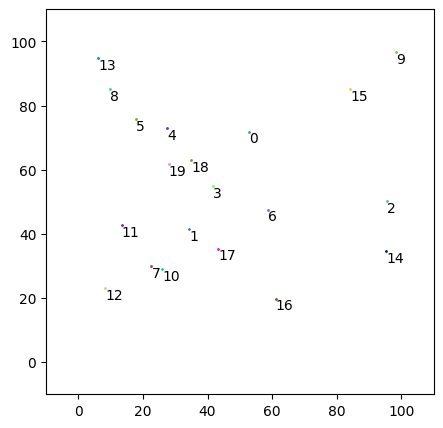

In [3]:
fig, ax = geoVeRoPy.plotNodes(
    nodes = nodes, 
    boundingBox = (0, 100, 0, 100)
)
fig, ax = geoVeRoPy.plotNodeSeq(
    fig = fig,
    ax = ax,
    nodes = nodes, 
    nodeSeq = InsertionAnd2Opt['seq'])

In [22]:
GA = geoVeRoPy.solveTSP(
    nodes = nodes,
    edges = 'Euclidean',
    algo = 'Metaheuristic',
    cons = 'Random',
    popSize = 100,
    meta = 'GeneticAlgorithm',
    neighRatio = {
        'swap': 0.1,
        'exchange': 0.1,
        'rotate': 0.2,
        'crossover': 0.7
    },
    stop = {
        'runtime': 10
    })

In [23]:
GA['ofv']

2645.138732529308

In [16]:
SA = geoVeRoPy.solveTSP(
    nodes = nodes,
    edges = 'Euclidean',
    algo = 'Metaheuristic',
    cons = 'Random',
    meta = 'SimulatedAnnealing',
    initTemp = 100,
    lengTemp = 10,
    coolRate = 0.98,
    neighRatio = {
        'swap': 0.2,
        'exchange': 0.2,
        'rotate': 0.6,
    },
    stop = {
        'runtime': 10
    })

In [17]:
SA['ofv']

842.4704409006507

In [ ]:
TS = geoVeRoPy.solveTSP(
    nodes = nodes,
    edges = 'Euclidean',
    algo = 'Metaheuristic',
    cons = 'Random',
    meta = 'TabuSearch',
    maxTabuListLength = 1000,
    neighNum = 20,
    neighRatio = {
        'swap': 0.2,
        'exchange': 0.2,
        'rotate': 0.6,
    },
    stop = {
        'numNoImproveIter': 10
    })

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [19]:
TS['ofv']

876.7602416950735

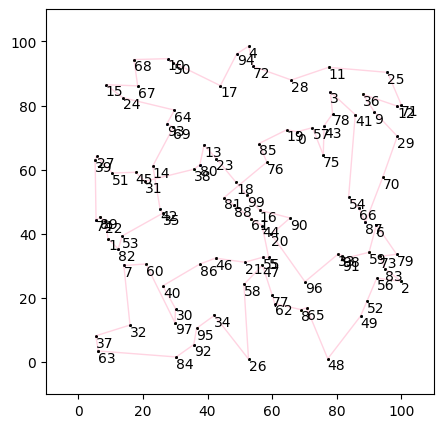

In [21]:
fig, ax = geoVeRoPy.plotNodes(
    nodes = nodes, 
    boundingBox = (0, 100, 0, 100)
)
fig, ax = geoVeRoPy.plotNodeSeq(
    fig = fig,
    ax = ax,
    nodes = nodes, 
    nodeSeq = TS['seq'])